In [5]:
import sys
sys.path.append('../src/')

import os
from typing import Dict
from os import PathLike
from pathlib import Path

import data_io

from harp.reader import create_reader

from aind_vr_foraging_analysis.utils import parse, processing, plotting_utils as plotting, AddExtraColumns

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages
from tkinter import font
from matplotlib.gridspec import GridSpec

from matplotlib.ticker import FuncFormatter, MaxNLocator, FixedLocator
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
from matplotlib.patches import Rectangle

def format_func(value, tick_number):
    return f"{value:.0f}"

from numpy.typing import ArrayLike
from typing import Literal, Tuple

sns.set_context('talk')

import warnings
pd.options.mode.chained_assignment = None  # Ignore SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [8]:
def load_calibration_data(session_path: str | PathLike):
    _out_dict = {}
    session_path = Path(session_path)
    # HarpBehavior = create_reader(device = r"C:\git\harp-tech\device.behavior\device.yml")
    # HarpOlfactometer = create_reader(device = r"C:\git\harp-tech\device.olfactometer\device.yml")
    # HarpLickometer = create_reader(device = r"C:\git\harp-tech\harp.device.lickety-split\software\bonsai\device.yml")

    HarpBehavior = create_reader(device = r"C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\git\harp-tech\device.behavior\device.yml")
    HarpOlfactometer = create_reader(device = r"C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\git\harp-tech\device.olfactometer\device.yml")
    HarpAnalogInput = create_reader(device = r"C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\git\harp-tech\device.analoginput\device.yml")
    HarpLickometer = create_reader(device = r"C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\git\harp-tech\harp.device.lickety-split\software\bonsai\device.yml")  

    if 'Behavior.harp' in os.listdir(session_path):
        _out_dict["harp_behavior"] = data_io.HarpSource(
            device=HarpBehavior,
            path= session_path / "Behavior.harp",
            name="behavior",
            autoload=False) 
        
    if 'Olfactometer.harp' in os.listdir(session_path):
        _out_dict["harp_olfactometer"] = data_io.HarpSource(
            device=HarpOlfactometer, 
            path=session_path / "Olfactometer.harp", 
            name="olfactometer", 
            autoload=False)

    if 'AnalogInput.harp' in os.listdir(session_path):
        _out_dict["harp_analog"] = data_io.HarpSource(
            device=HarpAnalogInput, 
            path=session_path / "AnalogInput.harp", 
            name="analog_input", 
            autoload=False)
        
    if 'Lickometer.harp' in os.listdir(session_path):
        _out_dict["harp_lickometer"] = data_io.HarpSource(
            device=HarpLickometer, 
            path=session_path / "Lickometer.harp", 
            name="lickometer", 
            autoload=False)
        
    _out_dict["software_events"] = data_io.SoftwareEventSource(
        path=session_path / "SoftwareEvents",
        name="software_events",
        autoload=False)

    # Load config old version
    if 'config.json' in os.listdir(session_path):
        with open(str(session_path)+'\config.json', 'r') as json_file:
            config = json.load(json_file)
            
    # Load new configuration
    else:
        _out_dict["config"] = data_io.ConfigSource(
            path=session_path / "Config",
            name="config",
            autoload=False)
    
    if 'OperationControl.harp' in os.listdir(session_path):
        _out_dict["operation_control"] = data_io.OperationControlSource(
            path=session_path / "OperationControl.harp",
            name="operation_control",
            autoload=False)
    else:
        pass
    return _out_dict
## ------------------------------------------------------------------------- ##


In [ ]:
def plot_olfactometer_calibration (data_set, data_analog, window= (-0.25, 2), duration: float = 1):
    trial_summary = pd.DataFrame()
    fig, axes = plt.subplots(1, 1, figsize=(5, 5))

    for start_reward, row in data_set.iterrows():
        trial_average = pd.DataFrame()
        trial = data_analog.loc[start_reward + window[0]: start_reward + window[1] + duration, 'Channel0']
        trial.index -=  start_reward
        trial_average['data'] = trial.values
        trial_average['times'] = np.around(trial.index,3)
        
        plt.plot(trial.index, trial.values, color='black', alpha=0.3)
        
        trial_summary = pd.concat([trial_summary, trial_average], ignore_index=True)

    plt.vlines(0, trial_summary.data.min(), trial_summary.data.max(), color='red', linestyle='--')
    plt.vlines(duration, trial_summary.data.min(), trial_summary.data.max(), color='indigo', linestyle='--')
    sns.despine()
    plt.grid(True)
    plt.show()


In [ ]:
def plot_olfactometer_calibration_multiple (dataset1, dataset2, dataset3, data_analog, window: tuple= (-0.25, 1), duration: float = 1, sharey: bool=False, substract_baseline=False):
    fig, ax = plt.subplots(1, 3, figsize=(14, 4), sharey=sharey, sharex=True)
    snippets = pd.DataFrame()
    for i, data_set in enumerate([dataset1, dataset2, dataset3]):
        trial_summary = pd.DataFrame()
        count=0
        for start_reward, row in data_set.iterrows():
            count+=1
            trial_average = pd.DataFrame()
            trial = data_analog.loc[start_reward + window[0]: start_reward + window[1] + duration, 'Channel0']

            if substract_baseline:
                trial_baseline = data_analog.loc[start_reward + window[0]: start_reward, 'Channel0'].mean()
                trial = trial - trial_baseline

            trial.index -=  start_reward
            trial_average['data'] = trial.values
            trial_average['times'] = np.around(trial.index,3)
            trial_average['odor'] = i
            
            ax[i].plot(trial.index, trial.values,  linewidth=0.5, label=count)
            
            trial_summary = pd.concat([trial_summary, trial_average], ignore_index=True)

        snippets = pd.concat([snippets, trial_summary], ignore_index=True)

        ax[i].vlines(0, trial_summary.data.min(), trial_summary.data.max(), color='red', linestyle='--')
        ax[i].vlines(duration, trial_summary.data.min(), trial_summary.data.max(), color='indigo', linestyle='--')
        ax[i].set_title(f"Valve {i}")
        ax[i].set_xlabel('Time (s)')
    ax[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Trial')

    sns.despine()
    plt.show()
    
    return snippets


In [49]:
session_path = r"Z:\scratch\vr-foraging\olfactometer_calibration\20241120T155214"
# session_path = r"Z:\scratch\vr-foraging\data\OlfactometerCalibration\20240301T160321"

save_path = r"Z:\scratch\vr-foraging\sessions\OdorCalibration"

session = session_path[65:73]
session_path = Path(session_path)

data = parse.load_session_data(session_path)

if 'harp_olfactometer' in data:
    data['harp_olfactometer'].streams.OdorValveState.load_from_file()
    data['harp_olfactometer'].streams.EndValveState.load_from_file()
    
data['harp_analog'].streams.AnalogData.load_from_file()
data_analog = data['harp_analog'].streams.AnalogData.data['Channel0'].reset_index()
data_analog.set_index('Time', inplace=True)

# Recover end valve triggers
endvalve = data['harp_olfactometer'].streams.EndValveState.data['EndValve0'].reset_index()
assert(np.round(endvalve.Time.diff().median(),1))
endvalve = endvalve.loc[endvalve.EndValve0 == 1]
endvalve.rename(columns={'EndValve0': 'data'}, inplace=True)

if 'Rawrig' in data['config'].streams:
    data['config'].streams.RawRig.load_from_file()
    rig = data['config'].streams.RawRig.data['rig_name']
    data['config'].streams.RawFullModel.load_from_file()
    if len(data['config'].streams.RawFullModel.data['operation_control']['stimulus_config']) == 3:
        odor_dict = {'0': data['config'].streams.RawFullModel.data['operation_control']['stimulus_config']['0']['odorant'],
        '1': data['config'].streams.RawFullModel.data['operation_control']['stimulus_config']['1']['odorant'],
        '2': data['config'].streams.RawFullModel.data['operation_control']['stimulus_config']['2']['odorant']}
    else:
        odor_dict = {'0': data['config'].streams.RawFullModel.data['operation_control']['stimulus_config']['0']['odorant']}
    
    duration = data['config'].streams.RawFullModel.data['operation_control']['time_on']

else:
    data['config'].streams.rig_input.load_from_file()
    rig = data['config'].streams.rig_input.data['rig_name']
    data['config'].streams.tasklogic_input.load_from_file()
    if len(data['config'].streams.tasklogic_input.data['task_parameters']['channel_config']) == 4:
        odor_dict = {'0': data['config'].streams.tasklogic_input.data['task_parameters']['channel_config']['0']['odorant'],
        '1': data['config'].streams.tasklogic_input.data['task_parameters']['channel_config']['1']['odorant'],
        '2': data['config'].streams.tasklogic_input.data['task_parameters']['channel_config']['2']['odorant']}
    else:
        odor_dict = {'0': data['config'].streams.tasklogic_input.data['operation_control']['stimulus_config']['0']['odorant']}
        
    duration = data['config'].streams.tasklogic_input.data['task_parameters']['time_on']

data['harp_olfactometer'].streams.Channel0ActualFlow.load_from_file()
data['harp_olfactometer'].streams.Channel0TargetFlow.load_from_file()

data['harp_olfactometer'].streams.Channel1ActualFlow.load_from_file()
data['harp_olfactometer'].streams.Channel1TargetFlow.load_from_file()

data['harp_olfactometer'].streams.Channel2ActualFlow.load_from_file()
data['harp_olfactometer'].streams.Channel2TargetFlow.load_from_file()

data['harp_olfactometer'].streams.Channel3ActualFlow.load_from_file()
data['harp_olfactometer'].streams.Channel3TargetFlow.load_from_file()

data['harp_olfactometer'].streams.Channel4ActualFlow.load_from_file()
data['harp_olfactometer'].streams.Channel4TargetFlow.load_from_file()

data['harp_olfactometer'].streams.Flowmeter.load_from_file()

### Toggle the odor valves while we keep the end valves open

In [52]:
valve0 = data['harp_olfactometer'].streams.OdorValveState.data['Valve0'].reset_index()
valve0.set_index('Time', inplace=True)
valve0 = valve0.loc[valve0.Valve0 == 1]

valve1 = data['harp_olfactometer'].streams.OdorValveState.data['Valve1'].reset_index()
valve1.set_index('Time', inplace=True)
valve1_close = valve1.index.diff()
valve1 = valve1.loc[valve1.Valve1 == 1]

valve2 = data['harp_olfactometer'].streams.OdorValveState.data['Valve2'].reset_index()
valve2.set_index('Time', inplace=True)
valve2 = valve2.loc[valve2.Valve2 == 1]

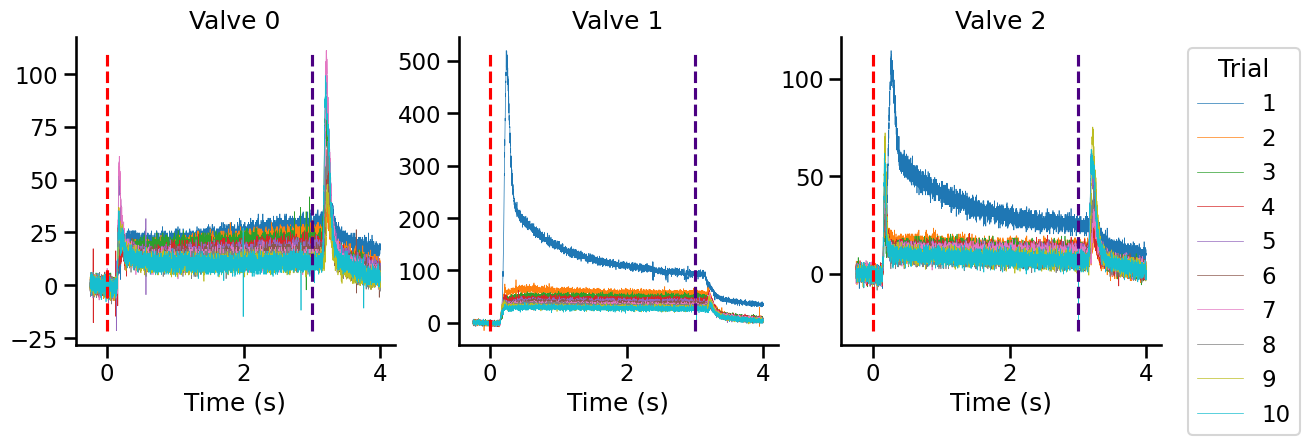

In [53]:
trial_summary_odor = plot_olfactometer_calibration_multiple(valve0.iloc[2:], valve1.iloc[1:], valve2.iloc[1:], data_analog, duration=duration, substract_baseline=True)

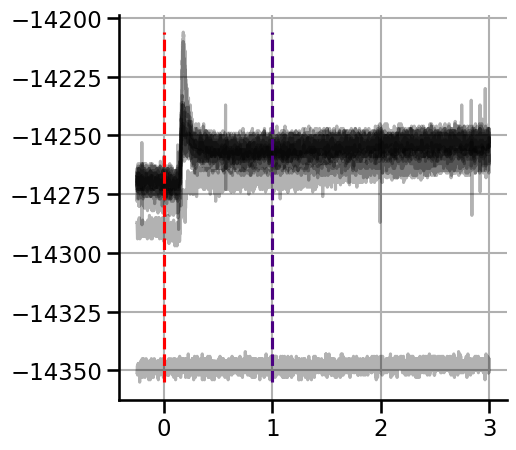

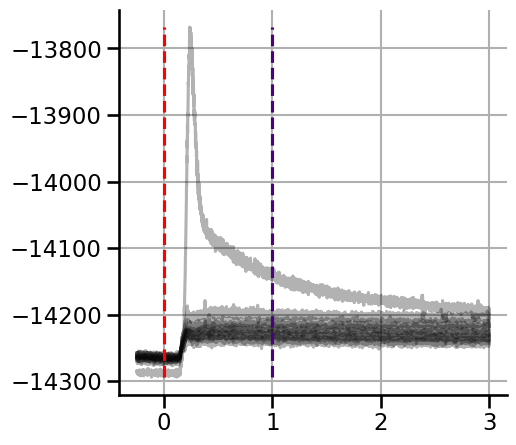

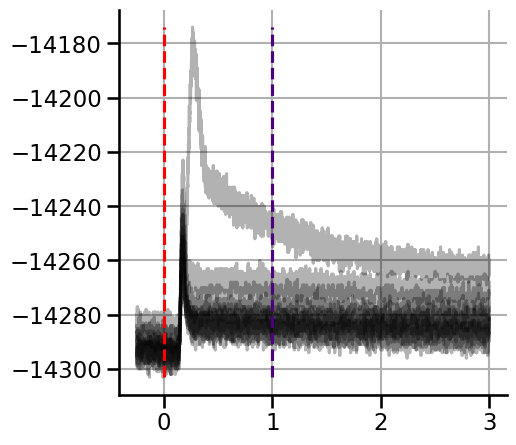

In [54]:
plot_olfactometer_calibration(valve0.iloc[1:], data_analog)
plot_olfactometer_calibration(valve1.iloc[1:], data_analog)
plot_olfactometer_calibration(valve2.iloc[1:], data_analog)

### Toggle the end valves and prepare the odor valves in advance

In [55]:
valve0['data']= np.where(valve0.Valve0 == 1, 'valve0', 0)
valve1['data']= np.where(valve1.Valve1 == 1, 'valve1', 0)
valve2['data']= np.where(valve2.Valve2 == 1, 'valve2', 0)

valves = pd.concat([valve0['data'], valve1['data'], valve2['data']], axis=0).reset_index()

new_df = pd.concat([endvalve, valves])
new_df.set_index('Time', inplace=True)
new_df.sort_index(inplace=True)

for index, row in new_df.iterrows():
    if row['data'] != True:
        value = row['data'][-1:]
    else:
        row['data'] = int(value)

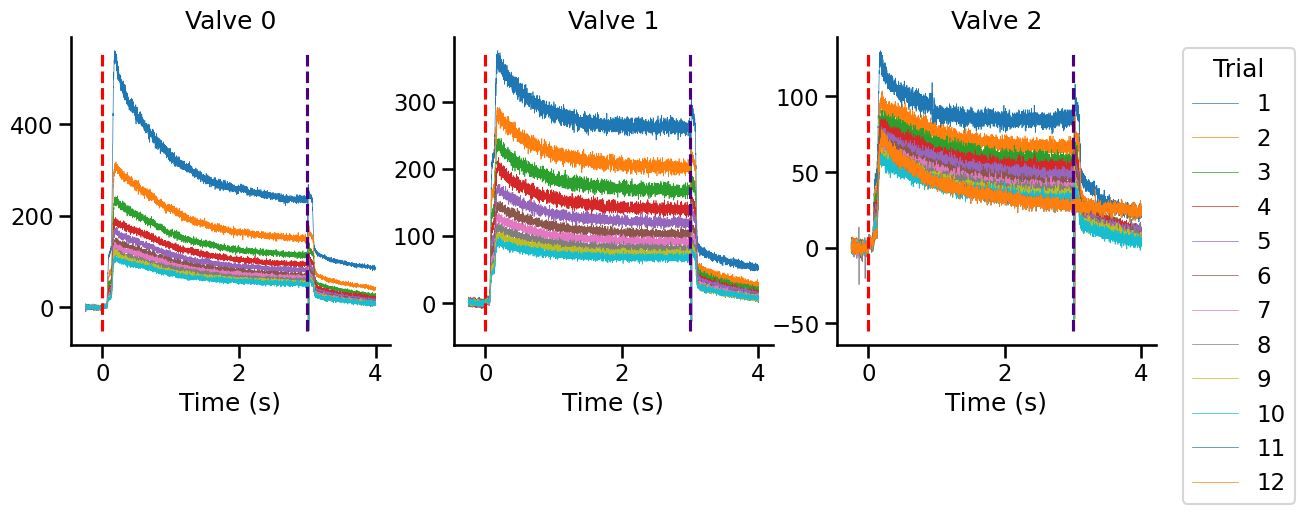

In [56]:
trial_summary_endvalves=plot_olfactometer_calibration_multiple(new_df.loc[new_df.data == 0].iloc[:-2], 
                                                               new_df.loc[new_df.data == 1].iloc[:-2], 
                                                               new_df.loc[new_df.data == 2].iloc[:-2], 
                                                               data_analog, 
                                                               duration =duration, 
                                                               sharey=False,
                                                               substract_baseline=True)

In [ ]:
plot_olfactometer_calibration(new_df.loc[new_df.data == 0].iloc[:-2], data_analog)
plot_olfactometer_calibration(new_df.loc[new_df.data == 1].iloc[:-2], data_analog)
plot_olfactometer_calibration(new_df.loc[new_df.data == 2].iloc[:-2], data_analog)

### Comparing both types of triggers

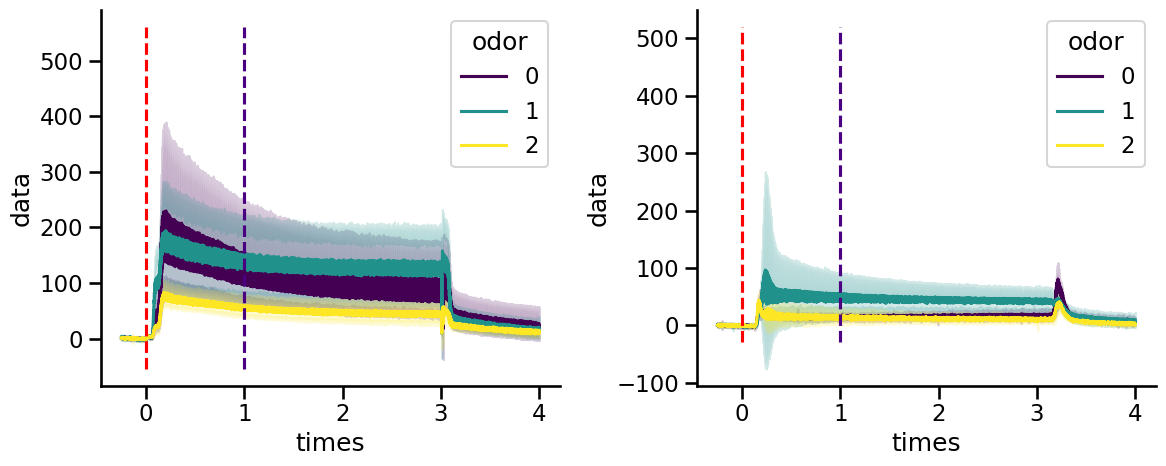

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

sns.lineplot(data=trial_summary_endvalves, x='times', y='data', hue='odor', palette='viridis', errorbar=('sd'), ax=ax[0])
ax[0].vlines(0, trial_summary_endvalves.data.min(), trial_summary_endvalves.data.max(), color='red', linestyle='--')
ax[0].vlines(1, trial_summary_endvalves.data.min(), trial_summary_endvalves.data.max(), color='indigo', linestyle='--')

sns.lineplot(data=trial_summary_odor, x='times', y='data', hue='odor', palette='viridis', errorbar=('sd'), ax=ax[1])
ax[1].vlines(0, trial_summary_odor.data.min(), trial_summary_odor.data.max(), color='red', linestyle='--')
ax[1].vlines(1, trial_summary_odor.data.min(), trial_summary_odor.data.max(), color='indigo', linestyle='--')
sns.despine()
plt.tight_layout()

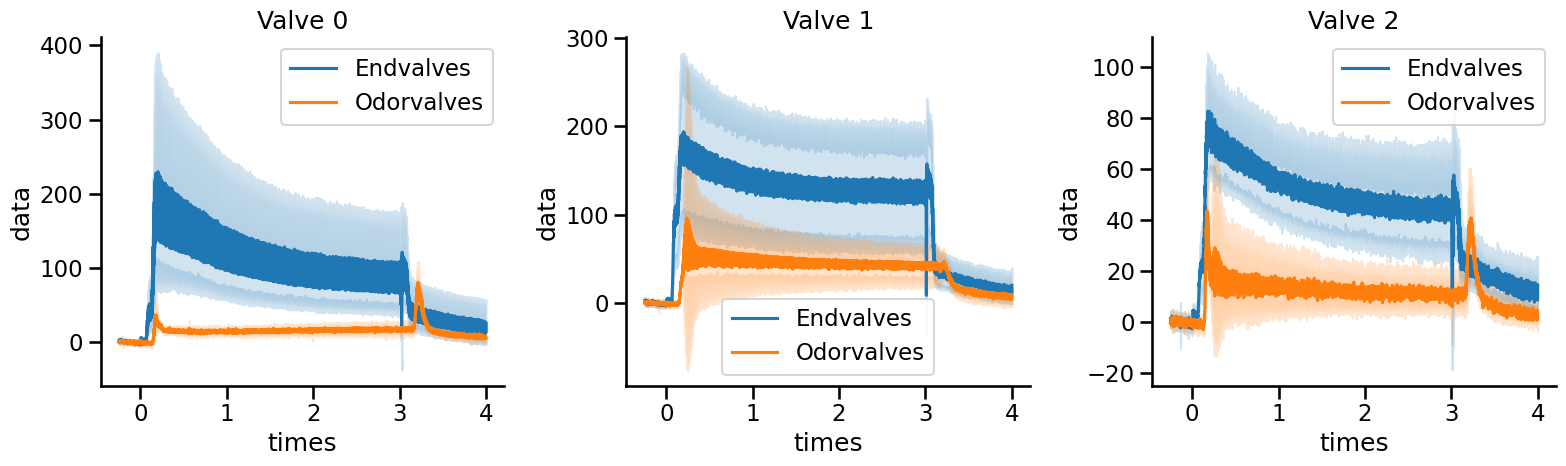

In [59]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5), sharex=True)
for odor in trial_summary_endvalves.odor.unique():
    sns.lineplot(data=trial_summary_endvalves.loc[trial_summary_endvalves.odor == odor], x='times', y='data', label='Endvalves', ci='sd', ax=ax[odor], palette = ['darkgreen', 'darkorange'])
    sns.lineplot(data=trial_summary_odor.loc[trial_summary_odor.odor == odor], x='times', y='data', label='Odorvalves', ci='sd', ax=ax[odor], palette = ['darkgreen', 'darkorange'])
    ax[odor].set_title(f"Valve {odor}")
sns.despine()
plt.tight_layout()

### Summary PDF with several plots

In [106]:
session_path = r"Z:\scratch\vr-foraging\olfactometer_calibration\20241120T155214"
save_path = r"Z:\scratch\vr-foraging\sessions\OdorCalibration"

In [107]:
session = session_path[65:73]
session_path = Path(session_path)

data = parse.load_session_data(session_path)

if 'harp_olfactometer' in data:
    data['harp_olfactometer'].streams.OdorValveState.load_from_file()
    data['harp_olfactometer'].streams.EndValveState.load_from_file()
    
data['harp_analog'].streams.AnalogData.load_from_file()
data_analog = data['harp_analog'].streams.AnalogData.data['Channel0'].reset_index()
data_analog.set_index('Time', inplace=True)

# Recover end valve triggers
endvalve = data['harp_olfactometer'].streams.EndValveState.data['EndValve0'].reset_index()
assert(np.round(endvalve.Time.diff().median(),1))
endvalve = endvalve.loc[endvalve.EndValve0 == 1]
endvalve.rename(columns={'EndValve0': 'data'}, inplace=True)

if 'Rawrig' in data['config'].streams:
    data['config'].streams.RawRig.load_from_file()
    rig = data['config'].streams.RawRig.data['rig_name']
    data['config'].streams.RawFullModel.load_from_file()
    if len(data['config'].streams.RawFullModel.data['operation_control']['stimulus_config']) == 3:
        odor_dict = {'0': data['config'].streams.RawFullModel.data['operation_control']['stimulus_config']['0']['odorant'],
        '1': data['config'].streams.RawFullModel.data['operation_control']['stimulus_config']['1']['odorant'],
        '2': data['config'].streams.RawFullModel.data['operation_control']['stimulus_config']['2']['odorant']}
    else:
        odor_dict = {'0': data['config'].streams.RawFullModel.data['operation_control']['stimulus_config']['0']['odorant']}
    
    duration = data['config'].streams.RawFullModel.data['operation_control']['time_on']

else:
    data['config'].streams.rig_input.load_from_file()
    rig = data['config'].streams.rig_input.data['rig_name']
    data['config'].streams.tasklogic_input.load_from_file()
    if len(data['config'].streams.tasklogic_input.data['task_parameters']['channel_config']) == 4:
        odor_dict = {'0': data['config'].streams.tasklogic_input.data['task_parameters']['channel_config']['0']['odorant'],
        '1': data['config'].streams.tasklogic_input.data['task_parameters']['channel_config']['1']['odorant'],
        '2': data['config'].streams.tasklogic_input.data['task_parameters']['channel_config']['2']['odorant']}
    else:
        odor_dict = {'0': data['config'].streams.tasklogic_input.data['operation_control']['stimulus_config']['0']['odorant']}
        
    duration = data['config'].streams.tasklogic_input.data['task_parameters']['time_on']
    
data['harp_olfactometer'].streams.Channel0ActualFlow.load_from_file()
data['harp_olfactometer'].streams.Channel0TargetFlow.load_from_file()

data['harp_olfactometer'].streams.Channel1ActualFlow.load_from_file()
data['harp_olfactometer'].streams.Channel1TargetFlow.load_from_file()

data['harp_olfactometer'].streams.Channel2ActualFlow.load_from_file()
data['harp_olfactometer'].streams.Channel2TargetFlow.load_from_file()

data['harp_olfactometer'].streams.Channel3ActualFlow.load_from_file()
data['harp_olfactometer'].streams.Channel3TargetFlow.load_from_file()

data['harp_olfactometer'].streams.Channel4ActualFlow.load_from_file()
data['harp_olfactometer'].streams.Channel4TargetFlow.load_from_file()

data['harp_olfactometer'].streams.Flowmeter.load_from_file()

valve0 = data['harp_olfactometer'].streams.OdorValveState.data['Valve0'].reset_index()
valve0.set_index('Time', inplace=True)
valve0 = valve0.loc[valve0.Valve0 == 1]

valve1 = data['harp_olfactometer'].streams.OdorValveState.data['Valve1'].reset_index()
valve1.set_index('Time', inplace=True)
valve1_close = valve1.index.diff()
valve1 = valve1.loc[valve1.Valve1 == 1]

valve2 = data['harp_olfactometer'].streams.OdorValveState.data['Valve2'].reset_index()
valve2.set_index('Time', inplace=True)
valve2 = valve2.loc[valve2.Valve2 == 1]

valve0['data']= np.where(valve0.Valve0 == 1, 'valve0', 0)
valve1['data']= np.where(valve1.Valve1 == 1, 'valve1', 0)
valve2['data']= np.where(valve2.Valve2 == 1, 'valve2', 0)

valves = pd.concat([valve0['data'], valve1['data'], valve2['data']], axis=0).reset_index()

new_df = pd.concat([endvalve, valves])
new_df.set_index('Time', inplace=True)
new_df.sort_index(inplace=True)

value = 0
for index, row in new_df.iterrows():
    if row['data'] != True:
        value = row['data'][-1:]
    else:
        row['data'] = int(value)

In [108]:
substract_baseline = True
window = (-0.25, duration+1.5)

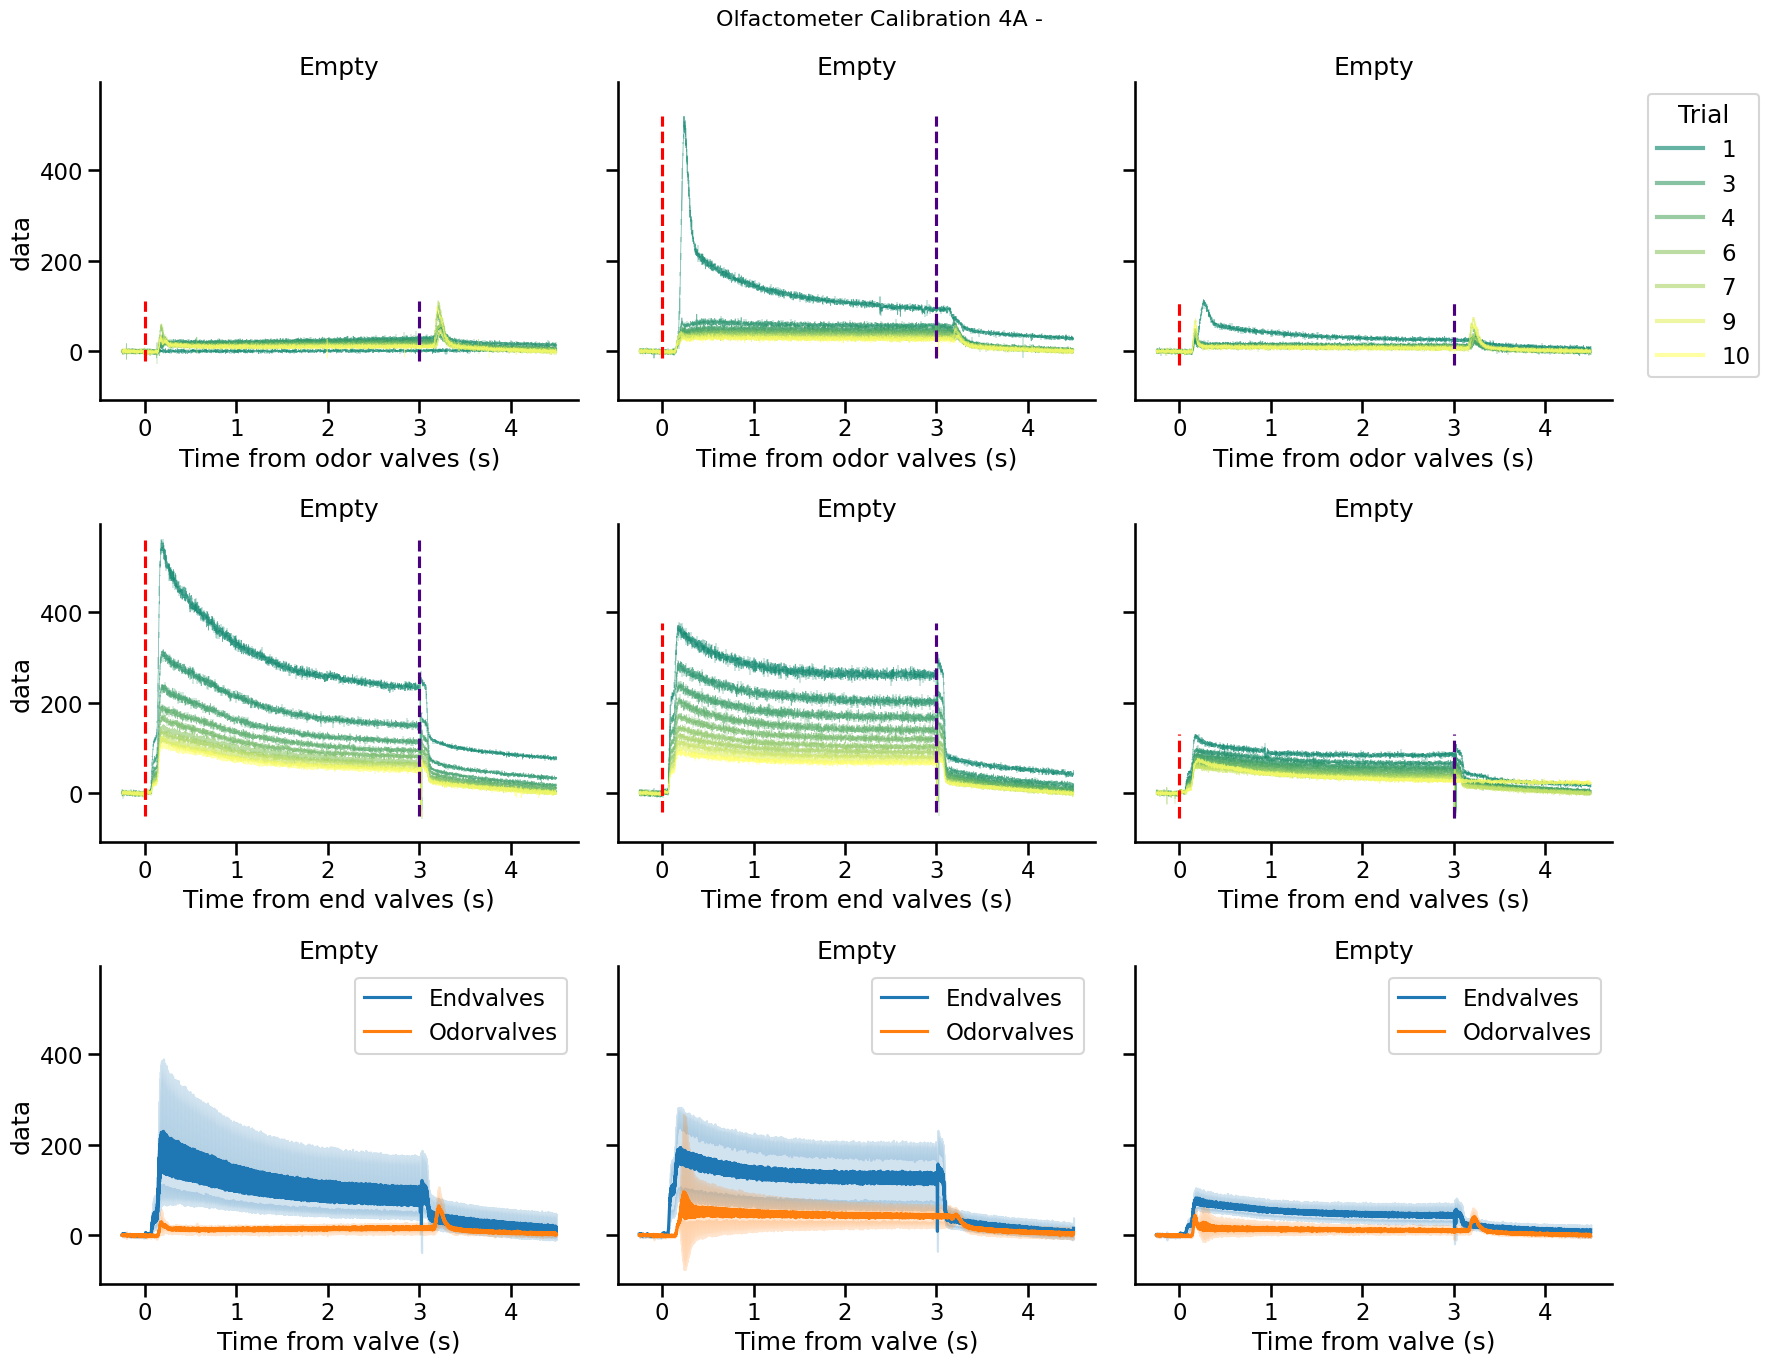

In [109]:
fig, ax = plt.subplots(3, 3, figsize=(18, 14), sharey=True)

dataset1 = valve0.iloc[1:]
dataset2 = valve1.iloc[1:]
dataset3 = valve2.iloc[1:]

legend_bool = False
snippets = pd.DataFrame()
for i, data_set in enumerate([dataset1, dataset2, dataset3]):
    count=0
    trial_summary = pd.DataFrame()
    for start_reward, row in data_set.iterrows():
        count+=1
        trial_average = pd.DataFrame()
        trial = data_analog.loc[start_reward + window[0]: start_reward + window[1], 'Channel0']

        if substract_baseline:
            trial_baseline = data_analog.loc[start_reward + window[0]: start_reward, 'Channel0'].mean()
            trial = trial - trial_baseline
            
        trial.index -=  start_reward
        trial_average['data'] = trial.values
        trial_average['times'] = np.around(trial.index,3)
        trial_average['odor'] = i
        trial_average['visit'] = count
        
        trial_summary = pd.concat([trial_summary, trial_average], ignore_index=True)
    if i ==2:
        legend_bool = True
    sns.lineplot(data=trial_summary.loc[trial_summary.odor ==i], x='times', y='data', hue='visit', ax=ax[0][i], palette='summer', ci='sd',  alpha=0.6, legend=legend_bool, linewidth=0.5)

    snippets = pd.concat([snippets, trial_summary], ignore_index=True)
    ax[0][i].vlines(0, trial_summary.data.min(), trial_summary.data.max(), color='red', linestyle='--')
    ax[0][i].vlines(duration, trial_summary.data.min(), trial_summary.data.max(), color='indigo', linestyle='--')
    ax[0][i].set_title(f"{odor_dict[str(i)]}")
    ax[0][i].set_xlabel('Time from odor valves (s)')

legend = ax[0][2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Trial')
for line in legend.get_lines():
    line.set_linewidth(3)
trial_summary_odor = snippets

dataset1 = new_df.loc[new_df.data == 0].iloc[:-2]
dataset2 = new_df.loc[new_df.data == 1].iloc[:-2]
dataset3 = new_df.loc[new_df.data == 2].iloc[:-2]

snippets = pd.DataFrame()
for i, data_set in enumerate([dataset1, dataset2, dataset3]):
    trial_summary = pd.DataFrame()  
    count=0
    for start_reward, row in data_set.iterrows():
        count+=1
        trial_average = pd.DataFrame()
        trial = data_analog.loc[start_reward + window[0]: start_reward + window[1], 'Channel0']
        
        if substract_baseline:
            trial_baseline = data_analog.loc[start_reward + window[0]: start_reward, 'Channel0'].mean()
            trial = trial - trial_baseline
            
        trial.index -=  start_reward
        trial_average['data'] = trial.values
        trial_average['times'] = np.around(trial.index,3)
        trial_average['odor'] = i
        trial_average['visit'] = count

        trial_summary = pd.concat([trial_summary, trial_average], ignore_index=True)
    
    sns.lineplot(data=trial_summary.loc[trial_summary.odor ==i], x='times', y='data', hue='visit', ax=ax[1][i], palette='summer', ci='sd',  alpha=0.6, legend=False, linewidth=0.5)
   
    snippets = pd.concat([snippets, trial_summary], ignore_index=True)
    ax[1][i].vlines(0, trial_summary.data.min(), trial_summary.data.max(), color='red', linestyle='--')
    ax[1][i].vlines(duration, trial_summary.data.min(), trial_summary.data.max(), color='indigo', linestyle='--')
    ax[1][i].set_title(f"{odor_dict[str(i)]}")

    ax[1][i].set_xlabel('Time from end valves (s)')

trial_summary_endvalves = snippets

for odor in trial_summary_endvalves.odor.unique():
    sns.lineplot(data=trial_summary_endvalves.loc[trial_summary_endvalves.odor == odor], x='times', y='data', label='Endvalves', ci='sd', ax=ax[2][odor], palette=['black', 'crimson'])
    sns.lineplot(data=trial_summary_odor.loc[trial_summary_odor.odor == odor], x='times', y='data', label='Odorvalves', ci='sd', ax=ax[2][odor], palette=['black', 'crimson'])
    ax[2][odor].set_title(f"{odor_dict[str(odor)]}")
    ax[2][odor].set_xlabel('Time from valve (s)')
    
plt.suptitle(f'Olfactometer Calibration {rig} - {session}', fontsize=16)
sns.despine()
plt.tight_layout()

if substract_baseline:
    fig.savefig(save_path + f'\\{rig} - {session}_calibration_substracted.pdf', format='pdf', bbox_inches='tight')
else:
    fig.savefig(save_path + f'\\{rig} - {session}_calibration.pdf', format='pdf', bbox_inches='tight')

In [90]:
def plot_olfactometer_calibration_multiple_flow (dataset1, dataset2, dataset3, data_analog, data, window: tuple= (-0.25, 1), duration: float = 1, sharey: bool=False, substract_baseline=False, title='End valves'):
    fig, ax = plt.subplots(3, 3, figsize=(18, 12), sharey=sharey, sharex=False, height_ratios=[1,1,1])
    snippets = pd.DataFrame()
    
    channel0= data['harp_olfactometer'].streams.Channel0ActualFlow.data
    channel1= data['harp_olfactometer'].streams.Channel1ActualFlow.data
    channel2= data['harp_olfactometer'].streams.Channel2ActualFlow.data
    channel3= data['harp_olfactometer'].streams.Channel3ActualFlow.data
    channel4= data['harp_olfactometer'].streams.Channel4ActualFlow.data
    legend_bool =False
    for i, data_set in enumerate([dataset1, dataset2, dataset3]):
        trial_summary = pd.DataFrame()
        flow_summary = pd.DataFrame()

        count=0
        for start_reward, row in data_set.iterrows():
            count+=1
            trial_average = pd.DataFrame()
            trial = data_analog.loc[start_reward + window[0]: start_reward + window[1] + duration, 'Channel0']

            if substract_baseline:
                trial_baseline = data_analog.loc[start_reward + window[0]: start_reward, 'Channel0'].mean()
                trial = trial - trial_baseline

            trial.index -=  start_reward
            trial_average['data'] = trial.values
            trial_average['times'] = np.around(trial.index,3)
            trial_average['odor'] = i
            trial_average['visit'] = count
                        
            trial_summary = pd.concat([trial_summary, trial_average], ignore_index=True)
            
            for number, data in enumerate([channel0, channel1, channel2, channel3, channel4]):
                flow_average = pd.DataFrame()

                columns = data.columns[0]
                data = data[[columns]]
                trial = data.loc[start_reward + window[0]: start_reward + window[1]+duration, columns]
                trial.index -=  start_reward
                flow_average['data'] = trial.values
                flow_average['times'] = np.around(trial.index,3)
                flow_average['visit'] = count
                flow_average['channel'] = number
                
                flow_summary = pd.concat([flow_summary, flow_average], ignore_index=True)
        if i ==2:
            legend_bool = True
        sns.lineplot(data=trial_summary.loc[trial_summary.odor==i], x='times', y='data', hue='visit', ax=ax[0][i], palette='summer', ci='sd',  alpha=0.6, legend=legend_bool, linewidth=0.5)
        
        legend = ax[0][2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Trial')
        for line in legend.get_lines():
            line.set_linewidth(3)
            
        temp_flow = flow_summary.loc[(flow_summary.channel==0)|(flow_summary.channel==1)|(flow_summary.channel==2)]
        channel_unit = str('Channel ' + str(temp_flow.loc[temp_flow.data !=0].channel.unique()[0]))
        print(channel_unit)
        sns.lineplot(data=temp_flow, x='times', y='data', hue='visit', ax=ax[1][i], palette='summer', ci='sd', legend=False, linewidth=1)
        ax[1][i].set_ylim(temp_flow.data.min(),temp_flow.data.max())
        ax[1][i].vlines(0, temp_flow.data.min(), temp_flow.data.max(), color='black', linestyle='--', linewidth=1)
        ax[1][i].vlines(duration, temp_flow.data.min(), temp_flow.data.max(), color='grey', linestyle='--', linewidth=1)
        ax[1][i].text(0.1, 0.9, channel_unit, horizontalalignment='center', verticalalignment='center', size=10, transform=ax[1][i].transAxes)
        
        temp_flow = flow_summary.loc[(flow_summary.channel==3)|(flow_summary.channel==4)]
        sns.lineplot(data=temp_flow, x='times', y='data', hue='visit', style='channel', ax=ax[2][i], palette='summer', ci='sd',   legend=False, linewidth=1)
        ax[2][i].set_ylim(temp_flow.data.min(),temp_flow.data.max())
        ax[2][i].vlines(0, temp_flow.data.min(), temp_flow.data.max(), color='black', linestyle='--', linewidth=1)
        ax[2][i].vlines(duration, temp_flow.data.min(), temp_flow.data.max(), color='grey', linestyle='--', linewidth=1)
        
        snippets = pd.concat([snippets, trial_summary], ignore_index=True)
        
        ax[0][i].vlines(0, trial_summary.data.min(), trial_summary.data.max(), color='black', linestyle='--', linewidth=1)
        ax[0][i].vlines(duration, trial_summary.data.min(), trial_summary.data.max(), color='grey', linestyle='--', linewidth=1)
        ax[0][i].set_title(f"{odor_dict[str(i)]}")
        ax[0][i].set_xlabel('Time (s)')
    
    plt.suptitle(f'{title} {rig} - {session}', fontsize=16)
    sns.despine()
    plt.tight_layout()
    fig.savefig(save_path + f'\\{rig} - {session}-{title}_calibration_flow.pdf', format='pdf', bbox_inches='tight')
    plt.show()

Channel 0
Channel 1
Channel 2


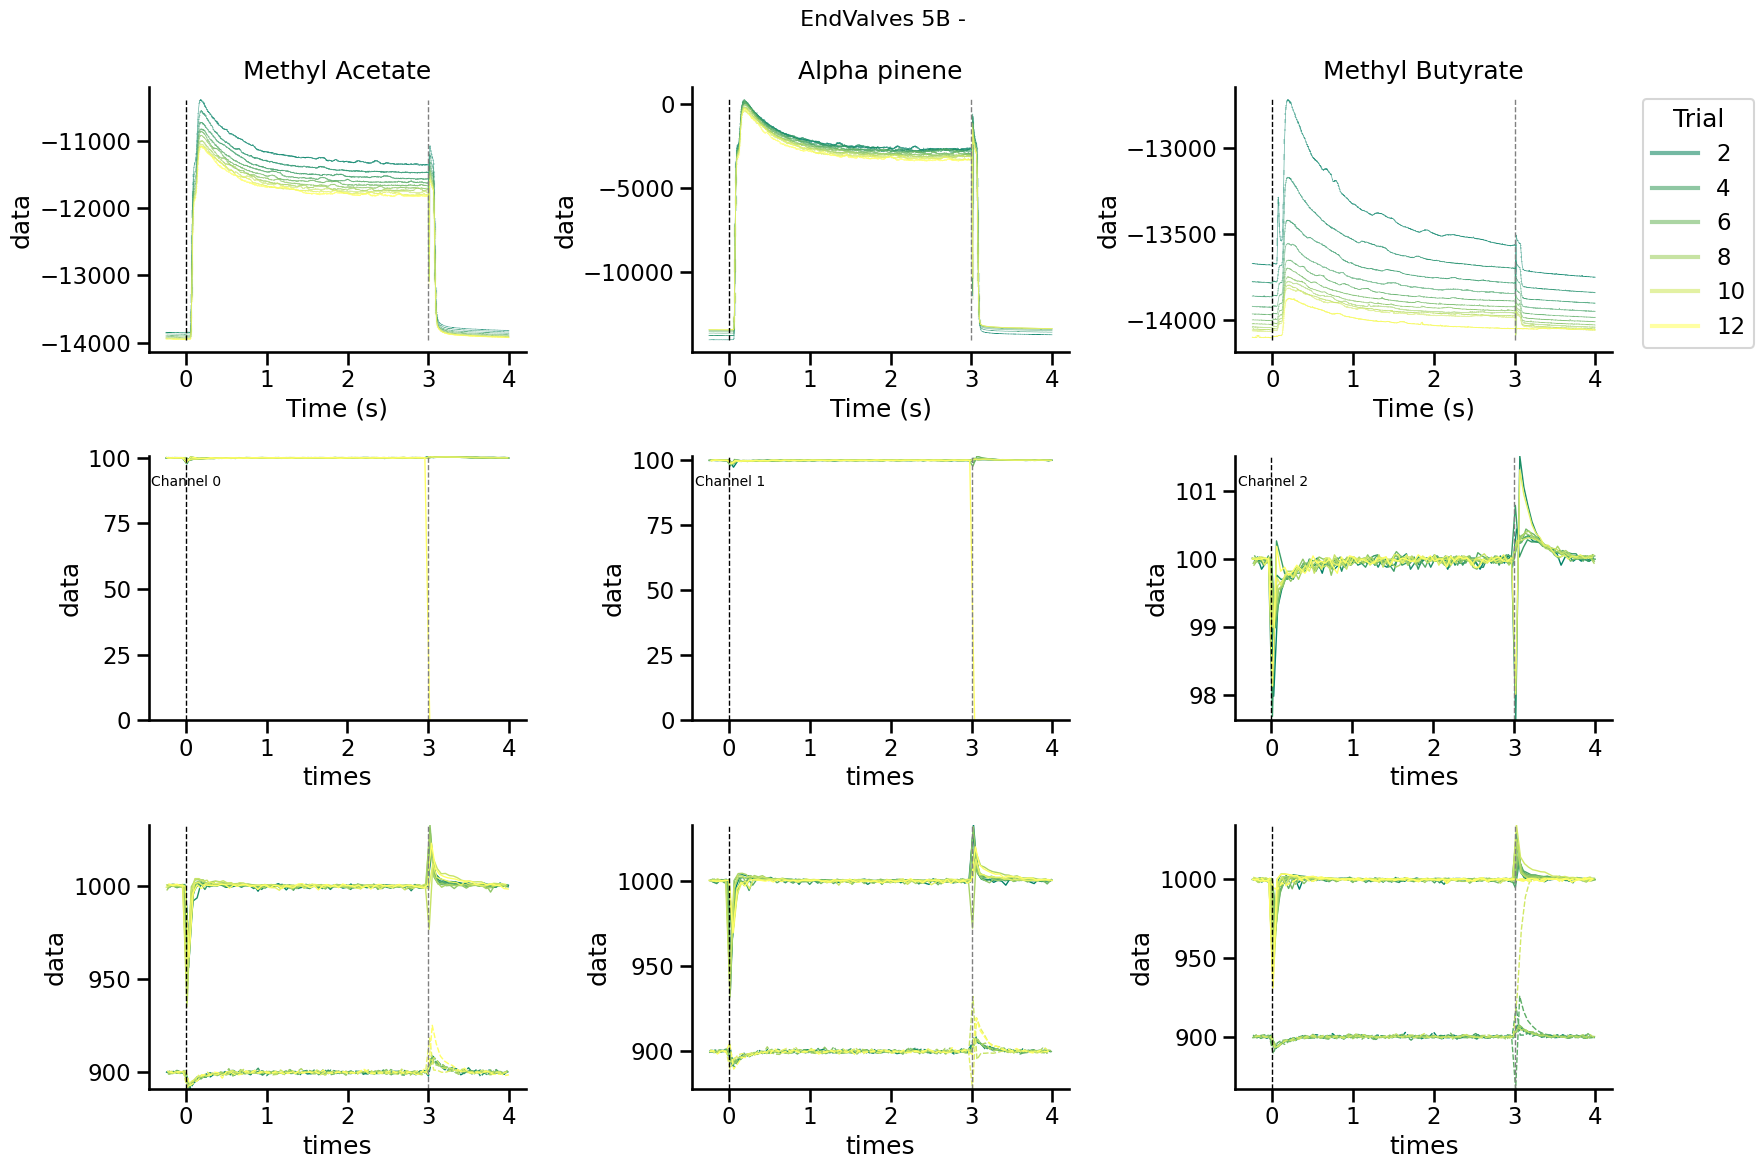

In [105]:
plot_olfactometer_calibration_multiple_flow(new_df.loc[new_df.data == 0].iloc[:-2], new_df.loc[new_df.data == 1].iloc[:-2], new_df.loc[new_df.data == 2].iloc[:-2], data_analog, data, duration =duration, title=' EndValves')

Channel 0
Channel 1
Channel 2


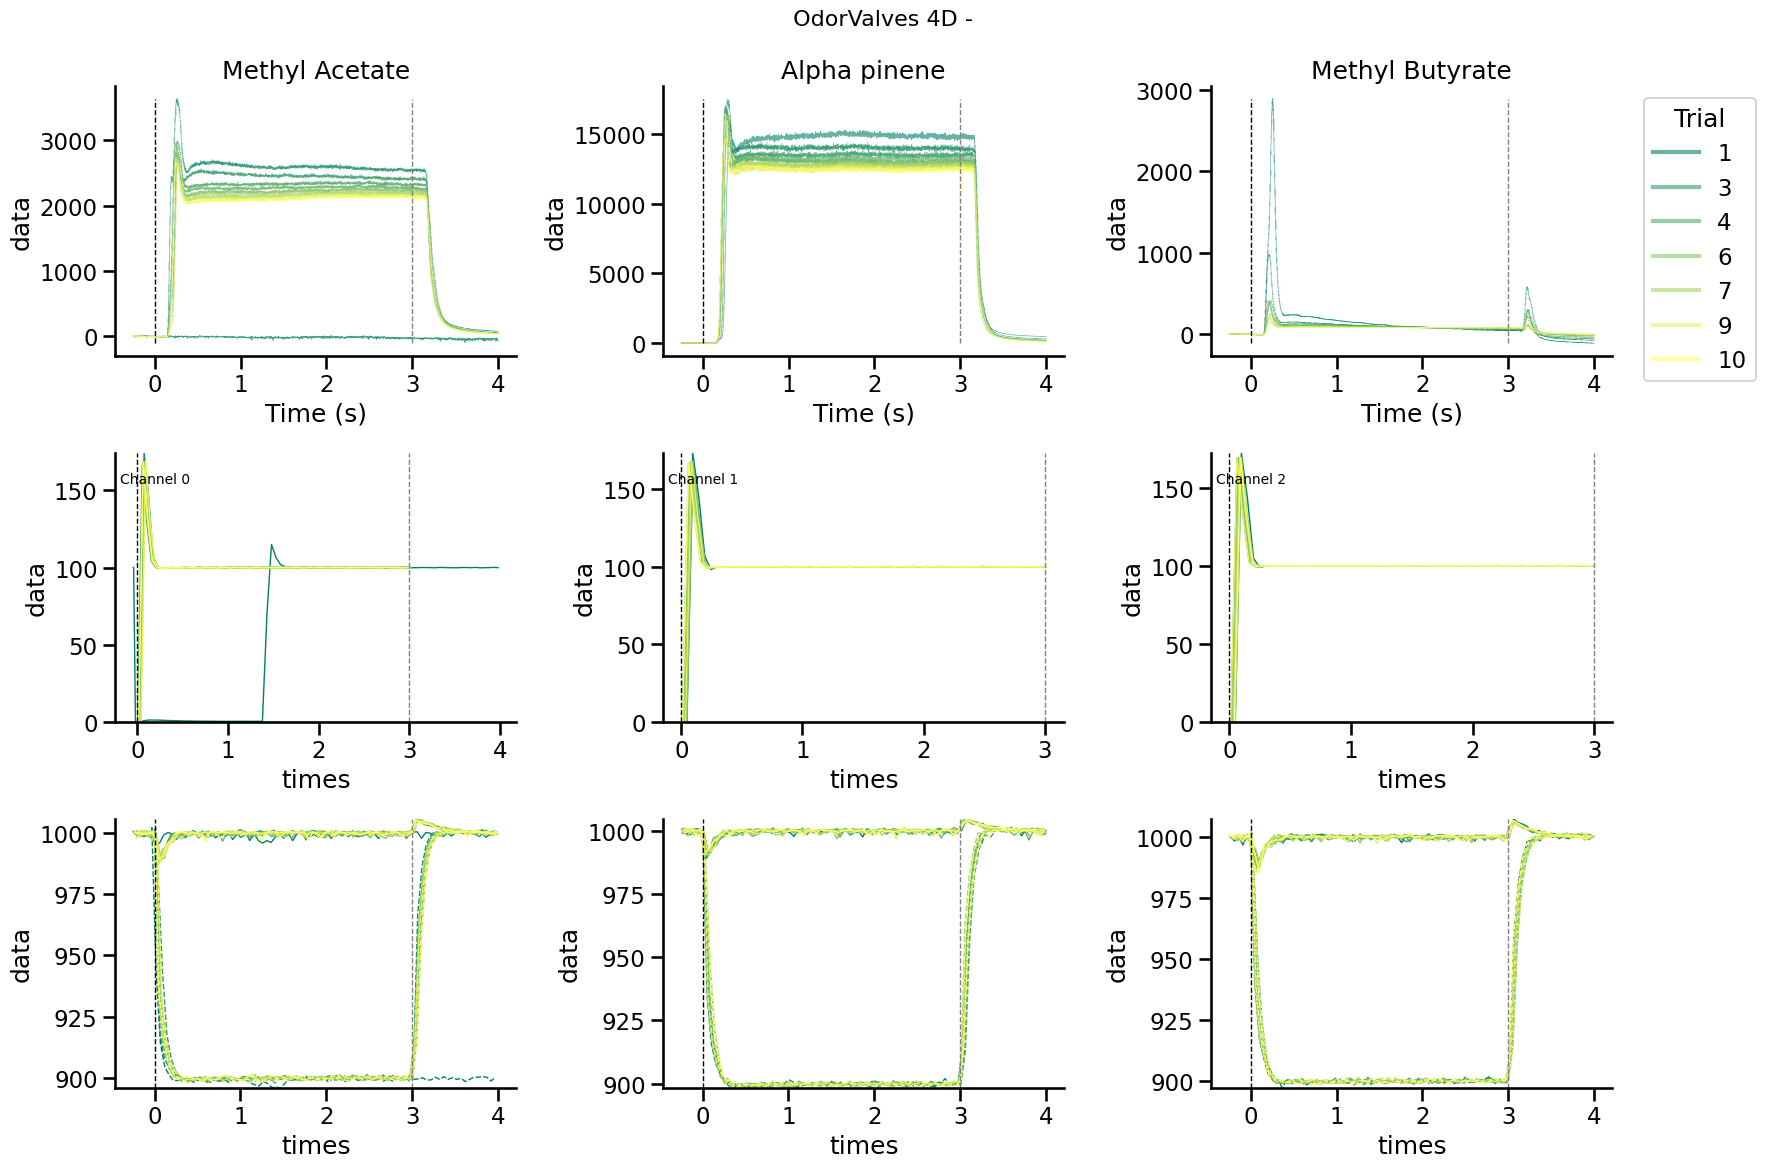

In [91]:
plot_olfactometer_calibration_multiple_flow(valve0.iloc[1:], valve1.iloc[1:], valve2.iloc[1:], data_analog, data, duration=duration, substract_baseline=True, title=' OdorValves')

### Summary for just one odor and all boxes summary

In [ ]:
end_valve_4C = pd.DataFrame()
odor_valve_4C = pd.DataFrame()
end_valve_4D = pd.DataFrame()
odor_valve_4D = pd.DataFrame()
end_valve_5A = pd.DataFrame()
odor_valve_5A = pd.DataFrame()
end_valve_5B = pd.DataFrame()
odor_valve_5B = pd.DataFrame()

base_path = r"Z:\scratch\vr-foraging\olfactometer_test\OlfactometerCalibration"

for day in ['20240415T154034', '20240407T181917', '20240407T170543','20240407T171450']:
    
    session_path = os.path.join(base_path, day)
    save_path = r"Z:\scratch\vr-foraging\sessions\OdorCalibration"

    session = session_path[65:73]
    session_path = Path(session_path)

    data = load_calibration_data(session_path)

    if 'harp_olfactometer' in data:
        data['harp_olfactometer'].streams.OdorValveState.load_from_file()
        data['harp_olfactometer'].streams.EndValveState.load_from_file()
        
    data['harp_analog'].streams['33'].load_from_file()
    data_analog = data['harp_analog'].streams['33'].data['Channel0'].reset_index()
    data_analog.set_index('Time', inplace=True)

    # Recover end valve triggers
    endvalve = data['harp_olfactometer'].streams.EndValveState.data['EndValve0'].reset_index()
    assert(np.round(endvalve.Time.diff().median(),1))
    endvalve = endvalve.loc[endvalve.EndValve0 == 1]
    endvalve.rename(columns={'EndValve0': 'data'}, inplace=True)

    data['config'].streams.RawRig.load_from_file()
    rig = data['config'].streams.RawRig.data['rig_name']

    data['config'].streams.RawFullModel.load_from_file()
    if len(data['config'].streams.RawFullModel.data['operation_control']['stimulus_config']) == 3:
        odor_dict = {'0': data['config'].streams.RawFullModel.data['operation_control']['stimulus_config']['0']['odorant'],
        '1': data['config'].streams.RawFullModel.data['operation_control']['stimulus_config']['1']['odorant'],
        '2': data['config'].streams.RawFullModel.data['operation_control']['stimulus_config']['2']['odorant']}
    
    elif '2' in data['config'].streams.RawFullModel.data['operation_control']['stimulus_config']:
        odor_dict = {'2': data['config'].streams.RawFullModel.data['operation_control']['stimulus_config']['2']['odorant']}
    else:
        odor_dict = {'0': data['config'].streams.RawFullModel.data['operation_control']['stimulus_config']['0']['odorant']}

    # duration = data['config'].streams.RawFullModel.data['operation_control']['time_off'] -  data['config'].streams.RawFullModel.data['operation_control']['time_on']
    duration = data['config'].streams.RawFullModel.data['operation_control']['time_on']

    data['harp_olfactometer'].streams.Channel0ActualFlow.load_from_file()
    data['harp_olfactometer'].streams.Channel0TargetFlow.load_from_file()

    data['harp_olfactometer'].streams.Channel1ActualFlow.load_from_file()
    data['harp_olfactometer'].streams.Channel1TargetFlow.load_from_file()

    data['harp_olfactometer'].streams.Channel2ActualFlow.load_from_file()
    data['harp_olfactometer'].streams.Channel2TargetFlow.load_from_file()

    data['harp_olfactometer'].streams.Channel3ActualFlow.load_from_file()
    data['harp_olfactometer'].streams.Channel3TargetFlow.load_from_file()

    data['harp_olfactometer'].streams.Channel4ActualFlow.load_from_file()
    data['harp_olfactometer'].streams.Channel4TargetFlow.load_from_file()

    data['harp_olfactometer'].streams.Flowmeter.load_from_file()

    substract_baseline = False
    window = (-0.25, 2)

    valve0 = data['harp_olfactometer'].streams.OdorValveState.data['Valve0'].reset_index()
    valve0.set_index('Time', inplace=True)
    valve0 = valve0.loc[valve0.Valve0 == 1]

    valve0['data']= np.where(valve0.Valve0 == 1, 'valve0', 0)

    valves = pd.concat([valve0['data']], axis=0).reset_index()

    new_df = pd.concat([endvalve, valves])
    new_df.set_index('Time', inplace=True)
    new_df.sort_index(inplace=True)

    for index, row in new_df.iterrows():
        if row['data'] != True:
            value = row['data'][-1:]
        else:
            row['data'] = int(value)
            
    if rig == '4C':
        end_valve_4C = new_df
        odor_valve_4C = valve0.iloc[1:]
        data_analog_4C = data_analog
    elif rig == '4D':
        end_valve_4D = new_df
        odor_valve_4D = valve0.iloc[1:]
        data_analog_4D = data_analog
    elif rig == '5A':
        end_valve_5A = new_df
        odor_valve_5A = valve0.iloc[1:]    
        data_analog_5A = data_analog
    elif rig == '5B' or rig == 'MR2':
        end_valve_5B = new_df
        odor_valve_5B = valve0.iloc[1:]  
        data_analog_5B = data_analog  

In [ ]:
substract_baseline = True
window = (-0.25, 2)
duration = 1

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(18, 14), sharey=True)
i=-1
for dataset1, dataset2,data_analog, rig in zip([odor_valve_4C, odor_valve_4D, odor_valve_5A], [end_valve_4C, end_valve_4D, end_valve_5A], [data_analog_4C, data_analog_4D, data_analog_5A], ['4C','4D', '5A']):
# for dataset1, dataset2,data_analog, rig in zip([odor_valve_4C, odor_valve_4D, odor_valve_5A, odor_valve_5B], [end_valve_4C, end_valve_4D, end_valve_5A,end_valve_5B], [data_analog_4C, data_analog_4D, data_analog_5A,data_analog_5B], ['4C','4D', '5A','5B']):
    i+=1
    legend_bool = False
    snippets = pd.DataFrame()
    data_set = dataset1
    count=0
    trial_summary = pd.DataFrame()
    for start_reward, row in data_set.iterrows():
        count+=1
        trial_average = pd.DataFrame()
        trial = data_analog.loc[start_reward + window[0]: start_reward + window[1], 'Channel0']
  
        if substract_baseline:
            trial_baseline = data_analog.loc[start_reward + window[0]: start_reward, 'Channel0'].mean()
            trial = trial - trial_baseline
        
        trial.index -=  start_reward
        trial_average['data'] = trial.values
        trial_average['times'] = np.around(trial.index,3)
        trial_average['odor'] = i
        trial_average['visit'] = count
        
        trial_summary = pd.concat([trial_summary, trial_average], ignore_index=True)
    if i == 2:
        legend_bool = True
    sns.lineplot(data=trial_summary.loc[trial_summary.odor ==i], x='times', y='data', hue='visit', ax=ax[0][i], palette='summer', ci='sd',  alpha=0.6, legend=legend_bool, linewidth=0.5)

    snippets = pd.concat([snippets, trial_summary], ignore_index=True)
    ax[0][i].vlines(0, trial_summary.data.min(), trial_summary.data.max(), color='red', linestyle='--')
    ax[0][i].vlines(duration, trial_summary.data.min(), trial_summary.data.max(), color='indigo', linestyle='--')
    ax[0][i].set_title(f'{rig} - {session}', fontsize=16)
    ax[0][i].set_xlabel('Time from odor valves (s)')

    legend = ax[0][2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Trial')
    for line in legend.get_lines():
        line.set_linewidth(3)
    trial_summary_odor = snippets

    data_set = dataset2.loc[dataset2.data == 0].iloc[:-2]

    snippets = pd.DataFrame()

    trial_summary = pd.DataFrame()  
    count=0
    for start_reward, row in data_set.iterrows():
        count+=1
        trial_average = pd.DataFrame()
        trial = data_analog.loc[start_reward + window[0]: start_reward + window[1], 'Channel0']
        
        if substract_baseline:
            trial_baseline = data_analog.loc[start_reward + window[0]: start_reward, 'Channel0'].mean()
            trial = trial - trial_baseline
            
        trial.index -=  start_reward
        trial_average['data'] = trial.values
        trial_average['times'] = np.around(trial.index,3)
        trial_average['odor'] = i
        trial_average['visit'] = count

        trial_summary = pd.concat([trial_summary, trial_average], ignore_index=True)
    
    sns.lineplot(data=trial_summary.loc[trial_summary.odor ==i], x='times', y='data', hue='visit', ax=ax[1][i], palette='summer', ci='sd',  alpha=0.6, legend=False, linewidth=0.5)

    snippets = pd.concat([snippets, trial_summary], ignore_index=True)
    ax[1][i].vlines(0, trial_summary.data.min(), trial_summary.data.max(), color='red', linestyle='--')
    ax[1][i].vlines(duration, trial_summary.data.min(), trial_summary.data.max(), color='indigo', linestyle='--')
    ax[1][i].set_xlabel('Time from end valves (s)')

    trial_summary_endvalves = snippets

    for odor in trial_summary_endvalves.odor.unique():
        sns.lineplot(data=trial_summary_endvalves.loc[trial_summary_endvalves.odor == odor], x='times', y='data', label='Endvalves', ci='sd', ax=ax[2][odor], palette=['black', 'crimson'])
        sns.lineplot(data=trial_summary_odor.loc[trial_summary_odor.odor == odor], x='times', y='data', label='Odorvalves', ci='sd', ax=ax[2][odor], palette=['black', 'crimson'])
        ax[2][odor].set_xlabel('Time from valve (s)')
        
    sns.despine()
    plt.tight_layout()

    # if substract_baseline:
    #     fig.savefig(save_path + f'\\{rig} - {session}_calibration_substracted.pdf', format='pdf', bbox_inches='tight')
    # else:
    #     fig.savefig(save_path + f'\\{rig} - {session}_calibration.pdf', format='pdf', bbox_inches='tight')

In [ ]:
substract_baseline = True
window = (-0.25, 5)
duration = 3

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(12, 12), sharey=True)
plt.grid(True) 

i=-1
# for dataset1, dataset2 in zip([odor_valve_4C, odor_valve_4D, odor_valve_5A, odor_valve_5B], [end_valve_4C, end_valve_4D, end_valve_5A, end_valve_5B]):
for dataset1, dataset2,data_analog, rig in zip([odor_valve_5B], [end_valve_5B], [data_analog_5B], ['5B']):
    legend_bool = False
    snippets = pd.DataFrame()
    data_set = dataset1
    count=0
    trial_summary = pd.DataFrame()
    for start_reward, row in data_set.iterrows():
        count+=1
        trial_average = pd.DataFrame()
        trial = data_analog.loc[start_reward + window[0]: start_reward + window[1], 'Channel0']
  
        if substract_baseline:
            trial_baseline = data_analog.loc[start_reward + window[0]: start_reward, 'Channel0'].mean()
            trial = trial - trial_baseline
        
        trial.index -=  start_reward
        trial_average['data'] = trial.values
        trial_average['times'] = np.around(trial.index,3)
        trial_average['odor'] = i
        trial_average['visit'] = count
        
        trial_summary = pd.concat([trial_summary, trial_average], ignore_index=True)
    
    legend_bool = True
    sns.lineplot(data=trial_summary.loc[trial_summary.odor ==i], x='times', y='data', hue='visit', ax=ax[0], palette='summer', ci='sd',  alpha=0.6, legend=legend_bool, linewidth=0.5)

    snippets = pd.concat([snippets, trial_summary], ignore_index=True)
    ax[0].set_title(f'{rig} - {session}', fontsize=16)
    ax[0].set_xlabel('Time from odor valves (s)')

    legend = ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Trial')
    for line in legend.get_lines():
        line.set_linewidth(3)
    trial_summary_odor = snippets

    data_set = dataset2.loc[dataset2.data == 0].iloc[:-2]

    snippets = pd.DataFrame()

    trial_summary = pd.DataFrame()  
    count=0
    for start_reward, row in data_set.iterrows():
        count+=1
        trial_average = pd.DataFrame()
        trial = data_analog.loc[start_reward + window[0]: start_reward + window[1], 'Channel0']
        
        if substract_baseline:
            trial_baseline = data_analog.loc[start_reward + window[0]: start_reward, 'Channel0'].mean()
            trial = trial - trial_baseline
            
        trial.index -=  start_reward
        trial_average['data'] = trial.values
        trial_average['times'] = np.around(trial.index,3)
        trial_average['odor'] = i
        trial_average['visit'] = count

        trial_summary = pd.concat([trial_summary, trial_average], ignore_index=True)
    
    sns.lineplot(data=trial_summary.loc[trial_summary.odor ==i], x='times', y='data', hue='visit', ax=ax[1], palette='summer', ci='sd',  alpha=0.6, legend=False, linewidth=0.5)

    snippets = pd.concat([snippets, trial_summary], ignore_index=True)
    ax[1].set_xlabel('Time from end valves (s)')

    trial_summary_endvalves = snippets

    for odor in trial_summary_endvalves.odor.unique():
        sns.lineplot(data=trial_summary_endvalves.loc[trial_summary_endvalves.odor == odor], x='times', y='data', label='Endvalves', ci='sd', ax=ax[2], palette=['black', 'crimson'])
        sns.lineplot(data=trial_summary_odor.loc[trial_summary_odor.odor == odor], x='times', y='data', label='Odorvalves', ci='sd', ax=ax[2], palette=['black', 'crimson'])
        ax[2].set_xlabel('Time from valve (s)')

    for i in range(3):
        ax[i].vlines(0, trial_summary.data.min(), trial_summary.data.max(), color='red', linestyle='--', linewidth=0.5)
        # ax[i].hlines(0, 0, 5, color='black', linestyle='--', linewidth=0.5)
        ax[i].vlines(duration, trial_summary.data.min(), trial_summary.data.max(), color='red', linestyle='--', linewidth=0.5)
        
    sns.despine()
    plt.tight_layout()
    plt.grid(True)  # Show grid
    
    if substract_baseline:
        fig.savefig(save_path + f'\\{rig} - {session}_calibration_substracted.pdf', format='pdf', bbox_inches='tight')
    else:
        fig.savefig(save_path + f'\\{rig} - {session}_calibration.pdf', format='pdf', bbox_inches='tight')

### Summary for just one odor one box

In [ ]:
from numpy import empty


end_valve = pd.DataFrame()
odor_valve = pd.DataFrame()
end_valve = pd.DataFrame()

base_path = r"Z:\scratch\vr-foraging\olfactometer_test\OlfactometerCalibration"

day = '20240415T154034'
    
session_path = os.path.join(base_path, day)
save_path = r"Z:\scratch\vr-foraging\sessions\OdorCalibration"

session = session_path[65:73]
session_path = Path(session_path)

data = load_calibration_data(session_path)

if 'harp_olfactometer' in data:
    data['harp_olfactometer'].streams.OdorValveState.load_from_file()
    data['harp_olfactometer'].streams.EndValveState.load_from_file()
    
data['harp_analog'].streams['33'].load_from_file()
data_analog = data['harp_analog'].streams['33'].data['Channel0'].reset_index()
data_analog.set_index('Time', inplace=True)

# Recover end valve triggers
endvalve = data['harp_olfactometer'].streams.EndValveState.data['EndValve0'].reset_index()
assert(np.round(endvalve.Time.diff().median(),1))
endvalve = endvalve.loc[endvalve.EndValve0 == 1]
endvalve.rename(columns={'EndValve0': 'data'}, inplace=True)

data['config'].streams.RawRig.load_from_file()
rig = data['config'].streams.RawRig.data['rig_name']

data['config'].streams.RawFullModel.load_from_file()
if len(data['config'].streams.RawFullModel.data['operation_control']['stimulus_config']) == 3:
    odor_dict = {'0': data['config'].streams.RawFullModel.data['operation_control']['stimulus_config']['0']['odorant'],
    '1': data['config'].streams.RawFullModel.data['operation_control']['stimulus_config']['1']['odorant'],
    '2': data['config'].streams.RawFullModel.data['operation_control']['stimulus_config']['2']['odorant']}

elif '2' in data['config'].streams.RawFullModel.data['operation_control']['stimulus_config']:
    odor_dict = {'2': data['config'].streams.RawFullModel.data['operation_control']['stimulus_config']['2']['odorant']}
else:
    odor_dict = {'0': data['config'].streams.RawFullModel.data['operation_control']['stimulus_config']['0']['odorant']}

# duration = data['config'].streams.RawFullModel.data['operation_control']['time_off'] -  data['config'].streams.RawFullModel.data['operation_control']['time_on']
duration = data['config'].streams.RawFullModel.data['operation_control']['time_on']

data['harp_olfactometer'].streams.Channel0ActualFlow.load_from_file()
data['harp_olfactometer'].streams.Channel0TargetFlow.load_from_file()

data['harp_olfactometer'].streams.Channel1ActualFlow.load_from_file()
data['harp_olfactometer'].streams.Channel1TargetFlow.load_from_file()

data['harp_olfactometer'].streams.Channel2ActualFlow.load_from_file()
data['harp_olfactometer'].streams.Channel2TargetFlow.load_from_file()

data['harp_olfactometer'].streams.Channel3ActualFlow.load_from_file()
data['harp_olfactometer'].streams.Channel3TargetFlow.load_from_file()

data['harp_olfactometer'].streams.Channel4ActualFlow.load_from_file()
data['harp_olfactometer'].streams.Channel4TargetFlow.load_from_file()

data['harp_olfactometer'].streams.Flowmeter.load_from_file()

if data['harp_olfactometer'].streams.OdorValveState.data.Valve0.unique() != False:
    triggered_valve = 'Valve0'
elif data['harp_olfactometer'].streams.OdorValveState.data.Valve1.unique() != False:
    triggered_valve = 'Valve1'
else:
    triggered_valve = 'Valve2'
    
valve = data['harp_olfactometer'].streams.OdorValveState.data[triggered_valve].reset_index()
valve.set_index('Time', inplace=True)
valve = valve.loc[valve[triggered_valve] == 1]
valve['data'] = np.where(valve[triggered_valve] == 1, triggered_valve, 0)

valves = pd.concat([valve['data']], axis=0).reset_index()
    
new_df = pd.concat([endvalve, valves])
new_df.set_index('Time', inplace=True)
new_df.sort_index(inplace=True)

value = triggered_valve[-1]
new_df['data'] = np.where(new_df.data == True, value, new_df.data)

end_valve = new_df
odor_valve = valve.iloc[1:]  
data_analog = data_analog  

In [ ]:
substract_baseline = True
window = (-0.25, 5)
duration = 3

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(12, 12), sharey=True)
plt.grid(True) 

i=triggered_valve[-1]
legend_bool = False
snippets = pd.DataFrame()
count=0
trial_summary = pd.DataFrame()
for start_reward, row in odor_valve.iterrows():
    count+=1
    trial_average = pd.DataFrame()
    trial = data_analog.loc[start_reward + window[0]: start_reward + window[1], 'Channel0']

    if substract_baseline:
        trial_baseline = data_analog.loc[start_reward + window[0]: start_reward, 'Channel0'].mean()
        trial = trial - trial_baseline
    
    trial.index -=  start_reward
    trial_average['data'] = trial.values
    trial_average['times'] = np.around(trial.index,3)
    trial_average['odor'] = i
    trial_average['visit'] = count
    
    trial_summary = pd.concat([trial_summary, trial_average], ignore_index=True)

legend_bool = True
sns.lineplot(data=trial_summary.loc[trial_summary.odor == i], x='times', y='data', hue='visit', ax=ax[0], palette='viridis', ci='sd',  alpha=0.6, legend=legend_bool, linewidth=0.5)

snippets = pd.concat([snippets, trial_summary], ignore_index=True)
ax[0].set_title(f'{rig} - {session}', fontsize=16)
ax[0].set_xlabel('Time from odor valves (s)')

legend = ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Trial')
for line in legend.get_lines():
    line.set_linewidth(3)
trial_summary_odor = snippets

end_valve = end_valve.loc[end_valve.data == i].iloc[:-2]

snippets = pd.DataFrame()

trial_summary = pd.DataFrame()  
count=0
for start_reward, row in end_valve.iterrows():
    count+=1
    trial_average = pd.DataFrame()
    trial = data_analog.loc[start_reward + window[0]: start_reward + window[1], 'Channel0']
    
    if substract_baseline:
        trial_baseline = data_analog.loc[start_reward + window[0]: start_reward, 'Channel0'].mean()
        trial = trial - trial_baseline
        
    trial.index -=  start_reward
    trial_average['data'] = trial.values
    trial_average['times'] = np.around(trial.index,3)
    trial_average['odor'] = i
    trial_average['visit'] = count

    trial_summary = pd.concat([trial_summary, trial_average], ignore_index=True)

sns.lineplot(data=trial_summary.loc[trial_summary.odor ==i], x='times', y='data', hue='visit', ax=ax[1], palette='viridis', ci='sd',  alpha=0.6, legend=True, linewidth=0.5)
legend = ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Trial')
for line in legend.get_lines():
    line.set_linewidth(3)
    
snippets = pd.concat([snippets, trial_summary], ignore_index=True)
ax[1].set_xlabel('Time from end valves (s)')

trial_summary_endvalves = snippets

for odor in trial_summary_endvalves.odor.unique():
    sns.lineplot(data=trial_summary_endvalves.loc[trial_summary_endvalves.odor == odor], x='times', y='data', label='Endvalves', ci='sd', ax=ax[2], palette=['black', 'crimson'])
    sns.lineplot(data=trial_summary_odor.loc[trial_summary_odor.odor == odor], x='times', y='data', label='Odorvalves', ci='sd', ax=ax[2], palette=['black', 'crimson'])
    ax[2].set_xlabel('Time from valve (s)')

for i in range(3):
    ax[i].vlines(0, trial_summary.data.min(), trial_summary.data.max(), color='red', linestyle='--', linewidth=0.5)
    # ax[i].hlines(0, 0, 5, color='black', linestyle='--', linewidth=0.5)
    ax[i].vlines(duration, trial_summary.data.min(), trial_summary.data.max(), color='red', linestyle='--', linewidth=0.5)
    
sns.despine()
plt.tight_layout()
plt.grid(True)  # Show grid

if substract_baseline:
    fig.savefig(save_path + f'\\{rig} - {session}_longtriggers_substracted.pdf', format='pdf', bbox_inches='tight')
else:
    fig.savefig(save_path + f'\\{rig} - {session}_longtriggers.pdf', format='pdf', bbox_inches='tight')

### Testing the possible bug in 5 rigs

In [ ]:
session_path = r"Z:\scratch\vr-foraging\data\699899\20240315T114710"  # Starting directory to search


In [ ]:
df_summary = pd.DataFrame()

session = session_path[-15:-7]
mouse = session_path[-22:-16]
session_path = Path(session_path)

data = analysis.load_session_data(session_path)

if 'harp_olfactometer' in data:
    data['harp_olfactometer'].streams.OdorValveState.load_from_file()
    data['harp_olfactometer'].streams.EndValveState.load_from_file()

data['harp_behavior'].streams.OutputSet.load_from_file()
data['harp_behavior'].streams.OutputClear.load_from_file()
data['config'].streams.TaskLogic.load_from_file()

reward_sites, active_site, encoder, config = analysis.parse_data(data)

patch_limit = analysis.choose_cut(reward_sites, 10)
reward_sites = reward_sites.loc[reward_sites.active_patch <= patch_limit]

In [ ]:
valve0 = data['harp_olfactometer'].streams.OdorValveState.data['Valve0'].reset_index()
valve0.set_index('Time', inplace=True)
valve0 = valve0.loc[valve0.Valve0 == 1]

valve1 = data['harp_olfactometer'].streams.OdorValveState.data['Valve1'].reset_index()
valve1.set_index('Time', inplace=True)
valve1_close = valve1.index.diff()
valve1 = valve1.loc[valve1.Valve1 == 1]

valve2 = data['harp_olfactometer'].streams.OdorValveState.data['Valve2'].reset_index()
valve2.set_index('Time', inplace=True)
valve2 = valve2.loc[valve2.Valve2 == 1]

In [ ]:
# Load treadmill data
# Maybe look at how the traces change with these two ways

encoder = encoder['Encoder']

treadmill_metadata = config.streams.Rig.data["treadmill"]
try:
    converter = treadmill_metadata["wheelDiameter"] * np.pi / treadmill_metadata["pulsesPerRevolution"] * (-1 if treadmill_metadata["invertDirection"] else 1)
except:
    converter = treadmill_metadata["wheel_diameter"] * np.pi / treadmill_metadata["pulses_per_revolution"] * (-1 if treadmill_metadata["invert_direction"] else 1)

encoder = encoder.apply(lambda x : x * converter)

encoder.index = pd.to_datetime(encoder.index, unit="s")
encoder = encoder.resample("33ms").sum().interpolate(method="linear") / 0.033
encoder.index = (encoder.index - pd.to_datetime(0))
encoder.index = encoder.index.total_seconds()

In [ ]:
# Recover end valve triggers
endvalve = data['harp_olfactometer'].streams.EndValveState.data['EndValve0'].reset_index()
assert(np.round(endvalve.Time.diff().median(),1))
endvalve = endvalve.loc[endvalve.EndValve0 == 1]
endvalve.rename(columns={'EndValve0': 'data'}, inplace=True)
endvalve.set_index('Time', inplace=True)

In [ ]:
# win = (0, 1500)
win = (2000,2100)

show_speed = True
save_name = "session_w_speed"

In [ ]:
data['harp_behavior'].streams.OutputSet.load_from_file()
data['harp_behavior'].streams.PulseSupplyPort0.load_from_file() # Duration of each pulse
data['harp_behavior'].streams.DigitalInputState.load_from_file()

# Find reward sites
sites = data['software_events'].streams.ActiveSite.data

zero_index = sites.index[0]

# Find ChoiceFeedback events (i.e. successful stops)
choice_feedback = data['software_events'].streams.ChoiceFeedback.data

# Check for licks
## mask for digital inputs

di_state = data['harp_behavior'].streams.DigitalInputState.data['DIPort0']
lick_onset = di_state.loc[di_state == True]

# Find give reward event
give_reward = data['harp_behavior'].streams.OutputSet.data[['SupplyPort0']]
give_reward = give_reward.loc[give_reward.SupplyPort0 == True]

# Find hardware reward events
pulse_duration = data['harp_behavior'].streams.PulseSupplyPort0.data
valve_output_pulse = data['harp_behavior'].streams.OutputSet.data['DOPort0']

label_dict = {
    "InterSite": '#808080',
    "Odor 1": '#d95f02',
    "Odor 2": '#1b9e77',
    "Odor 3": '#7570b3',
    "InterPatch": '#b3b3b3'}

fig, axs = plt.subplots(1,1, figsize=(20,4))

_legend = {}
done = True
for idx, site in enumerate(sites.iloc[:-1].iterrows()):
    site_label = site[1]['data']["label"]
    if site_label == "Reward":
        site_label = f"Odor {site[1]['data']['odor']['index']+1}"
        facecolor = label_dict[site_label]
    elif site_label == "RewardSite":
        site_label = f"Odor {site[1]['data']['odor_specification']['index']+1}"
        facecolor = label_dict[site_label]
    elif site_label == "InterPatch":
        facecolor = label_dict[site_label]
    else:
        site_label = "InterSite"
        facecolor = label_dict["InterSite"]

    p = Rectangle(
        (sites.index[idx] - zero_index, -2), sites.index[idx+1] - sites.index[idx], 8,
        linewidth = 0, facecolor = facecolor, alpha = .5)
    _legend[site_label] = p
    axs.add_patch(p)

s, lw = 400, 2
# Plotting raster
y_idx = -0.4
_legend["Choice Tone"] = axs.scatter(choice_feedback.index - zero_index+0.2,
           choice_feedback.index * 0 + y_idx,
           marker="s", s=100, lw=lw, c='darkblue',
           label="Choice Tone")
y_idx += 1
_legend["Lick"] = axs.scatter(lick_onset.index - zero_index,
           lick_onset.index * 0 + y_idx,
           marker="|", s=s, lw=lw, c='k',
           label="Lick")
_legend["Reward"] = axs.scatter(give_reward.index - zero_index,
           give_reward.index*0 + y_idx,
           marker=".", s=s, lw=lw, c='deepskyblue',
           label="Reward")

_legend["Odor"] = axs.scatter(endvalve.index - zero_index,
           endvalve.index*0 + y_idx,
           marker=".", s=s, lw=lw, c='yellow',
           label="Odor")
y_idx += 1

#ax.set_xticks(np.arange(0, sites.index[-1] - zero_index, 10))
axs.set_yticklabels([])
axs.set_xlabel("Time(s)")
axs.set_ylim(bottom=-1, top = 3)
axs.grid(False)
axs.set_xlim(win)

if show_speed:
    ax2 = axs.twinx()
    _legend["Velocity"] = ax2.plot(encoder.index - zero_index, encoder, c="k", label="Encoder", alpha = 0.8)[0]
    try:
        v_thr = config.streams.TaskLogic.data["operationControl"]["positionControl"]["stopResponseConfig"]["velocityThreshold"]
    except:
        v_thr = 8
    _legend["Stop Threshold"] = ax2.plot(ax2.get_xlim(), (v_thr, v_thr), c="k", label="Encoder", alpha = 0.5, lw = 2, ls = "--")[0]
    ax2.grid(False)
    ax2.set_ylim((-5, 70))
    ax2.set_ylabel("Velocity (cm/s)")
axs.legend(_legend.values(), _legend.keys(), bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)

# axs[0].stairs(software_events.streams.RewardAvailableInPatch.data["data"].values[:-1],
#           software_events.streams.RewardAvailableInPatch.data["data"].index.values -  zero_index,
#           lw = 3, color = 'k', fill=0)
axs.set_xlabel("Time(s)")
axs.grid(False)
axs.set_xlim(win)
# axs.get_xaxis().set_visible(False)
axs.set_ylim(bottom=-1, top = 4)
axs.set_yticks([0,3])
axs.yaxis.tick_right()

# if save_name is not None:
    # plt.savefig(janelia_figures + f"\{save_name}_time.svg", bbox_inches='tight', pad_inches=0.1, transparent=True)
plt.show()

### Test with task running and PID connected

The layout is the wheel connected in the quick connect and the PID on a side connected to the odor tube. 

In [ ]:
session_path = r"Z:\scratch\vr-foraging\olfactometer_test\OlfactometerCalibration\20240321T142602"  # Starting directory to search

df_summary = pd.DataFrame()

session = session_path[-15:-7]
mouse = session_path[-22:-16]
session_path = Path(session_path)

data = analysis.load_session_data(session_path)

if 'harp_olfactometer' in data:
    data['harp_olfactometer'].streams.OdorValveState.load_from_file()
    data['harp_olfactometer'].streams.EndValveState.load_from_file()

data['harp_behavior'].streams.OutputSet.load_from_file()
data['harp_behavior'].streams.OutputClear.load_from_file()
data['config'].streams.TaskLogic.load_from_file()

reward_sites, active_site, encoder, config = analysis.parse_data(data)

patch_limit = analysis.choose_cut(reward_sites, 10)
reward_sites = reward_sites.loc[reward_sites.active_patch <= patch_limit]

reward_sites['total_odor_time'] = reward_sites['odor_offset'] - reward_sites['odor_onset']

data['config'].streams.RawRig.load_from_file()
rig = data['config'].streams.RawRig.data['rig_name']

In [ ]:
data_analog = data['harp_behavior'].streams.AnalogData.data['AnalogInput0'].reset_index()
data_analog.set_index('Time', inplace=True)

In [ ]:
def plot_flow(ax, start, end, data, window= (-0.25, 1)):
    channel0= data['harp_olfactometer'].streams.Channel0ActualFlow.data
    channel1= data['harp_olfactometer'].streams.Channel1ActualFlow.data
    channel2= data['harp_olfactometer'].streams.Channel2ActualFlow.data
    channel3= data['harp_olfactometer'].streams.Channel3ActualFlow.data
    channel4= data['harp_olfactometer'].streams.Channel4ActualFlow.data
    
    for data in [channel3, channel4]:
        columns = data.columns[0]
        data = data[[columns]]
        trial = data.loc[start + window[0]: end + window[1], columns]
        ax[1].plot(trial.index-start, trial.values, label=columns)
        ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
    for data in [channel0, channel1, channel2]:
        columns = data.columns[0]
        data = data[[columns]]
        trial = data.loc[start + window[0]: end + window[1], columns]
        ax[2].plot(trial.index-start, trial.values, label=columns)
        ax[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
    ax[3].plot()
    ax[3].plot(channel0)


In [ ]:
def test_with_pid(data_set, data_analog, window= (-0.25, 2)):
    trial_summary = pd.DataFrame()
    
    for start_reward, row in data_set.iterrows():
        trial_average = pd.DataFrame()
        trial = data_analog.loc[row['odor_onset'] + window[0]: row['odor_offset'] + window[1], 'AnalogInput0']
        trial.index -=  start_reward
        trial_average['data'] = trial.values
        trial_average['times'] = np.around(trial.index,3)
    
        for column in reward_sites.columns:
            trial_average[column] = np.repeat(row[column], len(trial.values))
        
        # plt.plot(trial.index, trial.values, color='black', alpha=0.3)
        
        trial_summary = pd.concat([trial_summary, trial_average], ignore_index=True)
            
    # plt.vlines(0, trial_summary.data.min(), trial_summary.data.max(), color='red', linestyle='--')
    # plt.vlines(duration, trial_summary.data.min(), trial_summary.data.max(), color='indigo', linestyle='--')
    # plt.xlim(-0.5,2)
    # sns.despine()
    # plt.show()
    
    return trial_summary


In [ ]:
def test_with_pid_patches(data_set, data_analog, data, window= (-0.25, 1), save=False, sites = False, figsize=(20, 12)):
    fig, ax = plt.subplots(4, 1, figsize=figsize, height_ratios=[2, 1, 1, 1], sharex=True)
    
    if sites == False:
        start = data_set.loc[data_set['visit_number'] == 0]['odor_onset'].iloc[0]
        end = data_set.loc[data_set['visit_number'] == data_set['visit_number'].max()]['odor_offset'].iloc[0]
    else:
        start = data_set['odor_onset'].iloc[0]
        end = data_set['odor_offset'].iloc[0]
           
    trial = data_analog.loc[ start + window[0]: end + window[1], 'AnalogInput0']
    trial.index -=  start
    ax[0].plot(trial.index, trial.values, color='black', alpha=0.3)
    
    for index, row in data_set.iterrows():
        ax[0].vlines(row['odor_onset']-start, trial.min(), trial.max(), color='red', linestyle='--', alpha=0.5)
        ax[0].vlines(row['odor_offset']-start, trial.min(), trial.max(), color='indigo', linestyle='--', alpha=0.5)
        ax[0].barh(trial.max()-5, width=row['total_odor_time'], height=trial.max()/10, left=row['odor_onset']-start, edgecolor='darkgrey', linewidth=0.5)
        ax[0].vlines(index-start, trial.min(), trial.max(), color='yellow', linestyle='--', alpha=0.5)
        try:
            ax[0].scatter(row['stop_time']-start, (trial.max()+trial.min())/2, color='red', s=100)
        except:
            pass

        ## For flow
        ax[1].vlines(row['odor_onset']-start, 850, 1100, color='red', linestyle='--', alpha=0.5)
        ax[1].vlines(row['odor_offset']-start, 850, 1100, color='indigo', linestyle='--', alpha=0.5)
        
        ax[2].vlines(row['odor_onset']-start, 90, 110, color='red', linestyle='--', alpha=0.5)
        ax[2].vlines(row['odor_offset']-start, 90, 110, color='indigo', linestyle='--', alpha=0.5)
    
        
    plot_flow(ax, start, end, data, window=window)
    ax[0].set_title(f"Patch {data_set['active_patch'].iloc[0]} - {data_set['odor_label'].iloc[0]}")
    plt.xlabel('Time (s)')
    sns.despine()
    plt.show()
    
    if save != False:
        save.savefig(fig, bbox_inches='tight')
    plt.close()


In [ ]:
with PdfPages(save_path + f'\\{rig} - {session}_behavior_simulation.pdf') as pdf:
    for active_patch in reward_sites.active_patch.unique():
        test_with_pid_patches(reward_sites.loc[reward_sites.active_patch == active_patch], data_analog, data, save = pdf)

In [ ]:
with PdfPages(save_path + f'\\{rig} - {session}_behavior_simulation_patches.pdf') as pdf:
    trial_summary = test_with_pid(reward_sites, data_analog, window= (-0.25, 1))
    for patch in trial_summary.active_patch.unique():
        fig, ax = plt.subplots(1, 1, figsize=(15, 5))
        sns.lineplot(x='times', y='data', data=trial_summary.loc[trial_summary.active_patch == patch], hue='visit_number', palette='viridis', ci='sd')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.title(f'Patch {patch} - {trial_summary.loc[trial_summary.active_patch == patch].odor_label.unique()[0]}')
        sns.despine()
        plt.show()
        pdf.savefig(fig, bbox_inches='tight')

In [ ]:
with PdfPages(save_path + f'\\{rig} - {session}_behavior_simulation_sites.pdf') as pdf:
    trial_summary = test_with_pid(reward_sites, data_analog, window= (-0.25, 1))
    for patch in trial_summary.total_sites.unique():
        fig, ax = plt.subplots(1, 1, figsize=(15, 5))
        sns.lineplot(x='times', y='data', data=trial_summary.loc[trial_summary.total_sites == patch], hue='visit_number', palette='viridis', ci='sd')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        minimum = trial_summary.loc[trial_summary.total_sites == patch].data.min()
        maximum = trial_summary.loc[trial_summary.total_sites == patch].data.max()
        plt.vlines(0, minimum, maximum, color='red', linestyle='--', alpha=0.5)
        plt.vlines(max(trial_summary.loc[trial_summary.total_sites == patch].times)-1, minimum, maximum, color='indigo', linestyle='--', alpha=0.5)
        plt.title(f'Site {patch} - {trial_summary.loc[trial_summary.total_sites == patch].odor_label.unique()[0]}')
        sns.despine()
        plt.show()
        pdf.savefig(fig, bbox_inches='tight')

In [ ]:
with PdfPages(save_path + f'\\{rig} - {session}_behavior_simulation_sites.pdf') as pdf:
    for patch in trial_summary.total_sites.unique():
        test_with_pid_patches(reward_sites.loc[reward_sites.total_sites == patch], data_analog, data, save = pdf, sites = True, figsize=(10, 12))